### SI 670: Final Project Regression Model

#### Step 0. Import necessary libraries/packages and dataset

In [1]:
# Import libraries/packages
# Standard Python viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NFL library
import nfl_data_py as nfl

In [2]:
# Import NFL dataset
df = nfl.import_pbp_data([2022, 2023, 2024])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print dimensions of the dataframe
print(df.shape)

2022 done.
2023 done.
2024 done.
Downcasting floats.
(148591, 397)


In [3]:
# Define our necessary play types
fantasy_play_types = ['pass', 'run', 'qb_kneel']

# Define the play types to exclude from future consideration
exclude_play_types = [
    'no_play',       # Penalties/timeouts
    'qb_spike',      # QB stopping clock, no fantasy impact
    'field_goal',    # Kicker-specific
    'extra_point',   # Kicker-specific
    'punt',          # Defense/special teams
    'kickoff',       # Defense/special teams
]

# Filter DataFrame to include only fantasy_play_types
df_fantasy_plays = df[
    df['play_type'].isin(fantasy_play_types) & 
    ~df['play_type'].isin(exclude_play_types)
].copy()

print(f"Original plays: {len(df)}")
print(f"Plays retained for skill features: {len(df_fantasy_plays)}")

Original plays: 148591
Plays retained for skill features: 107413


In [4]:
mdl_cols = [
    # Identifiers and Context
    'game_id', 'play_id', 'season', 'week', 'posteam', 'defteam', 'home_team', 'away_team',
    
    # Player Identifiers
    'passer_player_id', 'passer', 'rusher_player_id', 'rusher', 'receiver_player_id', 'receiver', 'fumbled_1_player_id', 'fumbled_2_player_id',
    
    # Play Type and Situational Metrics
    'play_type', 'down', 'ydstogo', 'yardline_100', 'shotgun', 'no_huddle', 
    
    # Passing metrics
    'passing_yards', 'pass_touchdown', 'pass_attempt', 'complete_pass',
    
    # Rushing metrics
    'rushing_yards', 'rush_touchdown', 'rush_attempt',

    # Receiving metrics
    'receiving_yards', 'yards_after_catch',

    # Penalty/turnover metrics
    'penalty_yards', 'interception', 'fumble_lost',

    # Miscellaneous metrics
    'yards_gained', 'epa', 'cpoe', 'td_prob'
]

# Filter DataFrame for retained EDA columns
df_mdl0 = df_fantasy_plays[mdl_cols].copy()
print(f"Final DataFrame shape for feature engineering/modeling: {df_mdl0.shape}")

Final DataFrame shape for feature engineering/modeling: (107413, 38)


#### Step 1. Feature Engineering

1. Define fantasy score rules and target variable.

In [5]:

# Set scoring rules (Half-PPR for now)
scoring_rules = {
    'pass_yd': 0.04, 'pass_td': 4, 
    'rush_yd': 0.1, 'rush_td': 6, 
    'rec_yd': 0.1, 'rec_td': 6, 
    'rec': 0.5, # Half-PPR point per reception
    'int': -2, 'fumble_lost': -2,
    'qb_kneel_yd': -0.1
}

# Logic to calculate fantasy points for each play
def calculate_fantasy_points_per_play(df, scoring_rules):
    """Calculates all fantasy points earned on a single play based on half-PPR rules."""
    
    # Passing Points (QB)
    df['fp_pass'] = (df['passing_yards'].fillna(0) * scoring_rules['pass_yd']) + \
                    (df['pass_touchdown'].fillna(0) * scoring_rules['pass_td'])
                                
    # Rushing Points (RB/QB)
    df['fp_rush'] = (df['rushing_yards'].fillna(0) * scoring_rules['rush_yd']) + \
                    (df['rush_touchdown'].fillna(0) * scoring_rules['rush_td'])
                                
    # Receiving Points (WR/TE/RB)
    df['fp_rec'] = (df['receiving_yards'].fillna(0) * scoring_rules['rec_yd']) + \
                   (df['pass_touchdown'].fillna(0) * scoring_rules['rec_td']) + \
                   (df['complete_pass'].fillna(0) * scoring_rules['rec'])
    
    # Interception (for primary passer)
    df['fp_int'] = df['interception'].fillna(0) * scoring_rules['int']

    # Fumble Lost (for primary ball carrier/or receiver)
    df['fp_fumble_lost'] = df['fumble_lost'].fillna(0) * scoring_rules['fumble_lost']

    # QB Kneel Adjustment: Must be included in the target variable
    df['fp_kneel'] = np.where(df['play_type'] == 'qb_kneel', 
                              df['yards_gained'].fillna(0) * scoring_rules['qb_kneel_yd'], 0)
    
    return df

# Apply the calculation to the full DataFrame
df_mdl1 = calculate_fantasy_points_per_play(df_mdl0, scoring_rules)

In [9]:
# Calculate weekly fantasy points for each player and aggregate
def calculate_weekly_fantasy_points_final(df):
    """
    Calculates the total weekly fantasy points (Y) for each player by stacking
    contributions from passing, rushing, receiving, as well as any turnovers that occur.
    """
    
    # Calculate the total points for each respective player id
    
    # Total passing points: passing yards/td + interceptions + qb kneels
    df['fp_pass_total'] = df['fp_pass'].fillna(0) + \
                          df['fp_int'].fillna(0) + \
                          df['fp_kneel'].fillna(0)
    
    # Total rushing points: rushing yards/td
    df['fp_rush_total'] = df['fp_rush'].fillna(0)
    
    # Total receiving points: receiving yards/td + receptions for half point PPR
    df['fp_rec_total'] = df['fp_rec'].fillna(0)
    
    # Fumbles attributed to only the fumbled_1_player_id (rare cases where too, but going to ignore)
    df['fp_fumble_1_total'] = df['fp_fumble_lost'].fillna(0)
    
    
    # Specify ids for relevant fantasy time measureables
    id_vars = ['season', 'week']
    
    # Create directory to link point totals to the respective player ids
    contributions_map = {
        'passer_player_id': 'fp_pass_total',
        'rusher_player_id': 'fp_rush_total',
        'receiver_player_id': 'fp_rec_total',
        'fumbled_1_player_id': 'fp_fumble_1_total',
    }

    # Iterate through player ids to generate totals and store results under one player id column
    contributions = []
    for id_col, point_col in contributions_map.items():
        temp_df = df.rename(columns={id_col: 'player_id', point_col: 'points'})
        contributions.append(temp_df[id_vars + ['player_id', 'points']])

    # Stack contributions and drop any missing player ids
    df_all_points = pd.concat(contributions, ignore_index=True)
    df_all_points.dropna(subset=['player_id'], inplace=True)
    
    # Lastly, group by week and season for each respective player id and return that table
    df_target_Y = df_all_points.groupby(id_vars + ['player_id'])['points'].sum().reset_index()
    
    return df_target_Y.rename(columns={'points': 'Y_target_points'})


df_target_Y = calculate_weekly_fantasy_points_final(df_mdl1)

In [10]:
# Define how each feature column should be aggregated per player/week
feature_agg_rules = {
    'passing_yards': 'sum',
    'rushing_yards': 'sum',
    'receiving_yards': 'sum',
    'pass_touchdown': 'sum',
    'rush_touchdown': 'sum',
    'interception': 'sum',
    'epa': 'mean',
    'cpoe': 'mean',
}

# Define columns for time period aggregation and create feature column names from feature_agg_rules dictionary
id_vars = ['season', 'week'] 
feature_cols = list(feature_agg_rules.keys())

# Select only necessary columns from df_mdl1 dataframe: ids, feature columns and ids from original dataframe
df_select = df_mdl1[id_vars + feature_cols + ['passer_player_id', 'rusher_player_id', 'receiver_player_id']].copy()

# Reshape data using melt function to create a table that has multiple rows per play...one for each player
df_X_long = pd.melt(
    df_select,
    id_vars=id_vars + feature_cols,
    value_vars=['passer_player_id', 'rusher_player_id', 'receiver_player_id'],
    var_name='role_type',
    value_name='player_id'
)
df_X_long.dropna(subset=['player_id'], inplace=True)

# Aggregate features on a weekly level by player_id
df_features_X = df_X_long.groupby(['season', 'week', 'player_id']).agg(feature_agg_rules).reset_index()

# Determine how many total plays to determine how many plays the player was involved in for a week
df_counts = df_X_long.groupby(['season', 'week', 'player_id']).size().reset_index(name='total_plays_involved')

# Merge counts with features
df_features_X = pd.merge(df_features_X, df_counts, on=['season', 'week', 'player_id'], how='left')

print("Aggregated Feature DataFrame (X) - Fixed:")
print(df_features_X.head())

Aggregated Feature DataFrame (X) - Fixed:
   season  week   player_id  passing_yards  rushing_yards  receiving_yards  \
0    2022     1  00-0019596          212.0           -1.0            212.0   
1    2022     1  00-0023459          195.0           -1.0            195.0   
2    2022     1  00-0026143          352.0           12.0            352.0   
3    2022     1  00-0026158          309.0            0.0            309.0   
4    2022     1  00-0026498          240.0            2.0            240.0   

   pass_touchdown  rush_touchdown  interception       epa      cpoe  \
0             1.0             0.0           1.0 -0.012462  3.290235   
1             0.0             0.0           1.0 -0.298142 -2.784771   
2             1.0             0.0           1.0 -0.025235 -4.770667   
3             1.0             0.0           1.0 -0.208456 -4.062917   
4             1.0             0.0           3.0 -0.338503 -0.592032   

   total_plays_involved  
0                    31  
1         

In [11]:
# Merge our final set of features with the target variable
df_final = pd.merge(
    df_features_X, 
    df_target_Y,    
    on=['season', 'week', 'player_id'],
    how='left'
)

# If any instances where player didn't have points, set score to zero
df_final['Y_target_points'] = df_final['Y_target_points'].fillna(0)

# Sort data by week to properly create time based features
df_final.sort_values(by=['player_id', 'season', 'week'], inplace=True)

# Last week's points (lagged values)
df_final['Y_lag_1'] = df_final.groupby('player_id')['Y_target_points'].shift(1)

# 3 week rolling average
df_final['Y_roll_avg_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Career average up to that week
df_final['Y_cum_avg'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).mean()
)

# Any time features that are null, set to zero
time_features = ['Y_lag_1', 'Y_roll_avg_3', 'Y_cum_avg']
df_final[time_features] = df_final[time_features].fillna(0)

print("\nFinal Master DataFrame (df_final) is ready for ML modeling:")
print(df_final.head())


Final Master DataFrame (df_final) is ready for ML modeling:
      season  week   player_id  passing_yards  rushing_yards  receiving_yards  \
0       2022     1  00-0019596          212.0           -1.0            212.0   
318     2022     2  00-0019596          190.0           -2.0            190.0   
634     2022     3  00-0019596          271.0           -1.0            271.0   
943     2022     4  00-0019596          385.0            0.0            371.0   
1254    2022     5  00-0019596          351.0           -3.0            351.0   

      pass_touchdown  rush_touchdown  interception       epa       cpoe  \
0                1.0             0.0           1.0 -0.012462   3.290235   
318              1.0             0.0           0.0 -0.123334 -13.116215   
634              1.0             0.0           0.0 -0.165223   4.887816   
943              3.0             0.0           0.0  0.179459   5.982167   
1254             1.0             0.0           0.0  0.191188   0.707572   

 

In [ ]:
# Could each players role
role_counts = (
    df_X_long
    .groupby(['player_id', 'role_type'])
    .size()
    .reset_index(name='count')
)

# Pivot player and role
player_role_summary = (
    role_counts
    .pivot(index='player_id', columns='role_type', values='count')
    .fillna(0)
)

# Infer position function
def infer_position(row):
    pass_count = row.get('passer_player_id', 0)
    rush_count = row.get('rusher_player_id', 0)
    rec_count  = row.get('receiver_player_id', 0)

    if pass_count >= 50:
        return 'QB'
    if rush_count >= 10 and rush_count > rec_count * 2:
        return 'RB'
    if rec_count >= 10:
        return 'WR/TE'
    return 'OTH'

player_role_summary['position'] = player_role_summary.apply(infer_position, axis=1)

# lookup: player_id → inferred position
player_position_map = player_role_summary['position']

print("Sample inferred positions:")
print(player_position_map.head())


--- 6A. Inferring Position from Play Roles ---
Sample inferred positions:
player_id
00-0019596       QB
00-0022824      OTH
00-0023459       QB
00-0024243    WR/TE
00-0026143       QB
Name: position, dtype: object

--- Training Quantile Models ---
Training quantile 0.1
Training quantile 0.5
Training quantile 0.9
Finished training.

--- df_predictions (with position) ---
       y_test   pred_10   pred_50   pred_90  season  week   player_id position
12713     1.3  1.291554  1.303405  1.299159    2024     5  00-0038783    WR/TE
12977     1.0  0.999568  0.999622  0.999215    2024     6  00-0038783    WR/TE
13589     6.8  6.395825  6.830558  6.786877    2024     8  00-0038783    WR/TE
14463     7.7  5.638539  7.687661  7.737563    2024    11  00-0038783    WR/TE
15025     2.1  2.006413  2.130658  2.127563    2024    13  00-0038783    WR/TE

MAE (Median Prediction): 0.49

80% Prediction Interval Coverage:
Expected: 80%
Actual:   70.76%

Pinball Loss (10th Quantile): 0.1510

Example Predicti

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

id_cols = ['season', 'week', 'player_id']
target_col = 'Y_target_points'

# Keep ID columns for later joining
df_ids = df_final[id_cols].copy()

# Build X and y
X = df_final.drop(columns=id_cols + [target_col]).fillna(0)
y = df_final[target_col]

# Chronological split (90% train, 10% test)
split_point = int(len(X) * 0.90)

X_train = X.iloc[:split_point]
X_test  = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test  = y.iloc[split_point:]

ids_test = df_ids.iloc[split_point:]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train quantile models 10%, 50%, 90%
quantiles = [0.10, 0.50, 0.90]
y_preds = {}

print("\n--- Training Quantile Models ---")
for q in quantiles:
    print(f"Training quantile {q}")
    model = HistGradientBoostingRegressor(
        loss='quantile',
        quantile=q,
        max_depth=6,
        learning_rate=0.05,
        max_iter=500,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    y_preds[q] = model.predict(X_test_scaled)

print("Finished training.\n")


# ==============================================================
# 8. Build df_predictions WITH inferred position
# ==============================================================

df_predictions = pd.DataFrame({
    'y_test' : y_test.values,
    'pred_10': y_preds[0.10],
    'pred_50': y_preds[0.50],
    'pred_90': y_preds[0.90]
}, index=y_test.index)

# Add season, week, player_id
df_predictions = df_predictions.join(ids_test)

# Add inferred positions
df_predictions['position'] = df_predictions['player_id'].map(player_position_map)
df_predictions['position'] = df_predictions['position'].fillna('OTH')

print("--- df_predictions (with position) ---")
print(df_predictions.head())


# ==============================================================
# 9. Evaluation Metrics + Example Row
# ==============================================================

def pinball_loss(y_true, y_pred, q):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, q * err, (1 - q) * -err))

# MAE
mae = mean_absolute_error(df_predictions['y_test'], df_predictions['pred_50'])
print(f"\nMAE (Median Prediction): {mae:.2f}")

# 80% PI coverage
coverage = (
    (df_predictions['y_test'] >= df_predictions['pred_10']) &
    (df_predictions['y_test'] <= df_predictions['pred_90'])
).mean() * 100

print(f"\n80% Prediction Interval Coverage:")
print(f"Expected: 80%")
print(f"Actual:   {coverage:.2f}%")

# Pinball loss (10th percentile)
pb10 = pinball_loss(df_predictions['y_test'], df_predictions['pred_10'], 0.10)
print(f"\nPinball Loss (10th Quantile): {pb10:.4f}")

# Example row for poster
example_row = df_predictions.iloc[0]
print("\nExample Prediction Interval:")
print(example_row)


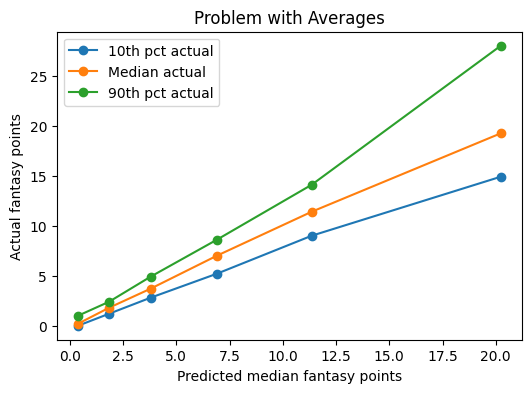

In [13]:
# df_predictions needs at least: y_test, pred_50
df_bin = df_predictions.copy()
df_bin["pred_bin"] = pd.qcut(df_bin["pred_50"], q=6, duplicates="drop")
grouped = df_bin.groupby("pred_bin")

x = grouped["pred_50"].mean()
p10 = grouped["y_test"].quantile(0.10)
p50 = grouped["y_test"].quantile(0.50)
p90 = grouped["y_test"].quantile(0.90)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x, p10, marker="o", label="10th pct actual")
ax.plot(x, p50, marker="o", label="Median actual")
ax.plot(x, p90, marker="o", label="90th pct actual")

ax.set_xlabel("Predicted median fantasy points")
ax.set_ylabel("Actual fantasy points")
ax.set_title("Problem with Averages")
plt.grid(False)
ax.legend()

plt.show() 

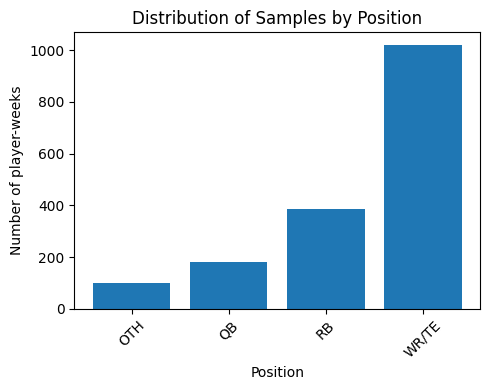

In [14]:
import matplotlib.pyplot as plt

counts = df_predictions['position'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(counts.index, counts.values)
ax.set_xlabel('Position')
ax.set_ylabel('Number of player-weeks')
ax.set_title('Distribution of Samples by Position')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd

# Baseline example: predict last week's actual for the same player
# (you may already have something; adjust as needed)
# Here I assume df_predictions already has a column `baseline_pred`
metrics = []

def model_metrics(name, y_true, y_pred_50, y_pred_10, y_pred_90):
    mae = np.mean(np.abs(y_true - y_pred_50))
    coverage = np.mean((y_true >= y_pred_10) & (y_true <= y_pred_90))
    width = np.mean(y_pred_90 - y_pred_10)
    return dict(Model=name, MAE=mae, Coverage80=coverage, AvgWidth=width)

# Quantile model
metrics.append(
    model_metrics(
        "Quantile Reg.",
        df_predictions['y_test'],
        df_predictions['pred_50'],
        df_predictions['pred_10'],
        df_predictions['pred_90']
    )
)

# (Optional) Baseline if you have pred_baseline column
if 'pred_baseline' in df_predictions.columns:
    # give it a dummy, very wide interval so it's fair
    baseline_50 = df_predictions['pred_baseline']
    baseline_10 = baseline_50 - 5
    baseline_90 = baseline_50 + 5
    metrics.append(
        model_metrics(
            "Baseline",
            df_predictions['y_test'],
            baseline_50,
            baseline_10,
            baseline_90
        )
    )

results_df = pd.DataFrame(metrics)
print(results_df)


           Model       MAE  Coverage80  AvgWidth
0  Quantile Reg.  0.493181    0.707592  1.525057


/var/folders/qp/q8km7l1x0w7_zhsgwzlhx10m0000gn/T/ipykernel_65245/496747624.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cov_by_pos.index, rotation=45)


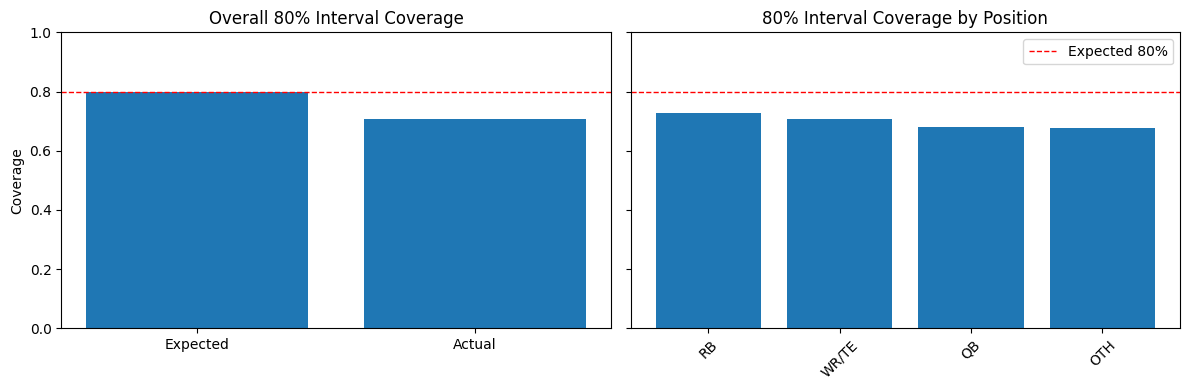

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

expected_coverage = 0.80

# overall coverage
overall_coverage = np.mean(
    (df_predictions['y_test'] >= df_predictions['pred_10']) &
    (df_predictions['y_test'] <= df_predictions['pred_90'])
)

# coverage by position
cov_by_pos = df_predictions.groupby('position').apply(
    lambda d: np.mean(
        (d['y_test'] >= d['pred_10']) &
        (d['y_test'] <= d['pred_90'])
    )
).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Left: overall
ax = axes[0]
ax.bar(['Expected', 'Actual'], [expected_coverage, overall_coverage])
ax.set_ylim(0, 1)
ax.set_ylabel('Coverage')
ax.set_title('Overall 80% Interval Coverage')
ax.axhline(expected_coverage, color='r', linestyle='--', linewidth=1)

# Right: by position
ax = axes[1]
ax.bar(cov_by_pos.index, cov_by_pos.values)
ax.axhline(expected_coverage, color='r', linestyle='--', linewidth=1, label='Expected 80%')
ax.set_title('80% Interval Coverage by Position')
ax.set_xticklabels(cov_by_pos.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


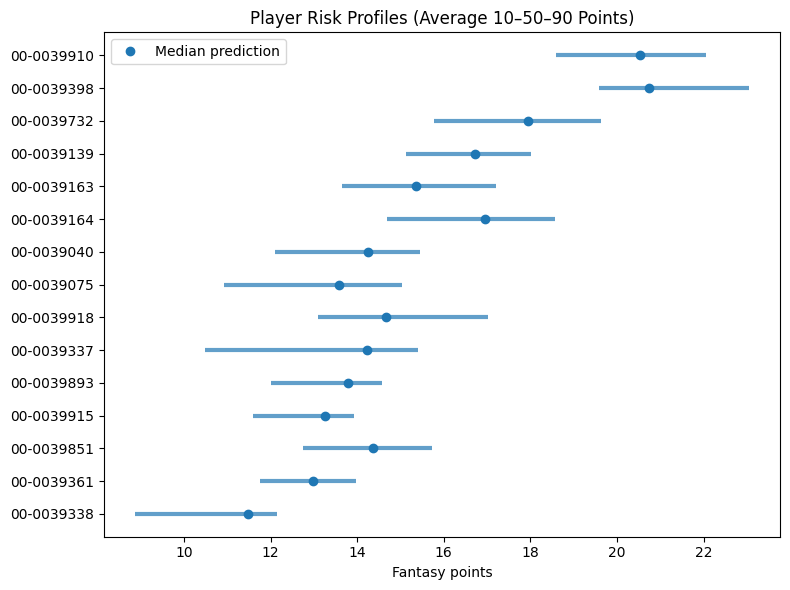

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

N = 15  # number of players to show

# Average over all weeks for each player
agg = df_predictions.groupby(['player_id']).agg(
    avg_y=('y_test', 'mean'),
    avg_q10=('pred_10', 'mean'),
    avg_q50=('pred_50', 'mean'),
    avg_q90=('pred_90', 'mean')
)

# Pick top N by average actual points
agg = agg.sort_values('avg_y', ascending=False).head(N)

y_pos = np.arange(len(agg))

fig, ax = plt.subplots(figsize=(8, 6))

# Interval lines from avg_q10 to avg_q90
ax.hlines(y_pos, agg['avg_q10'], agg['avg_q90'], linewidth=3, alpha=0.7)
# Median markers
ax.plot(agg['avg_q50'], y_pos, 'o', label='Median prediction')

ax.set_yticks(y_pos)
ax.set_yticklabels(agg.index.get_level_values('player_id'))
ax.set_xlabel('Fantasy points')
ax.set_title('Player Risk Profiles (Average 10–50–90 Points)')
ax.invert_yaxis()  # best player at top
ax.legend()

plt.tight_layout()
plt.show()

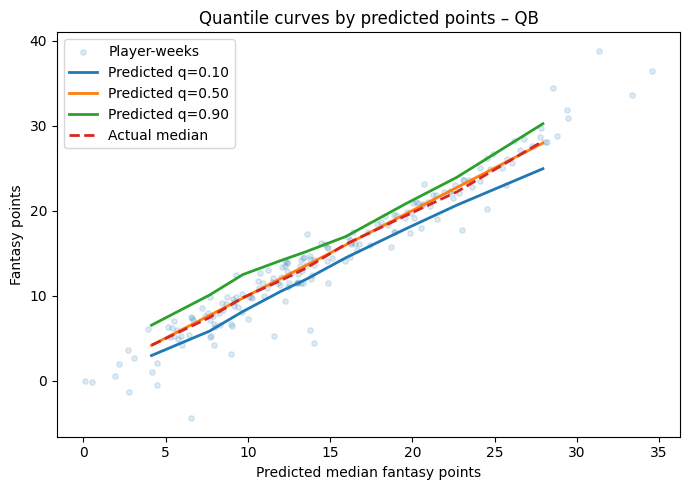

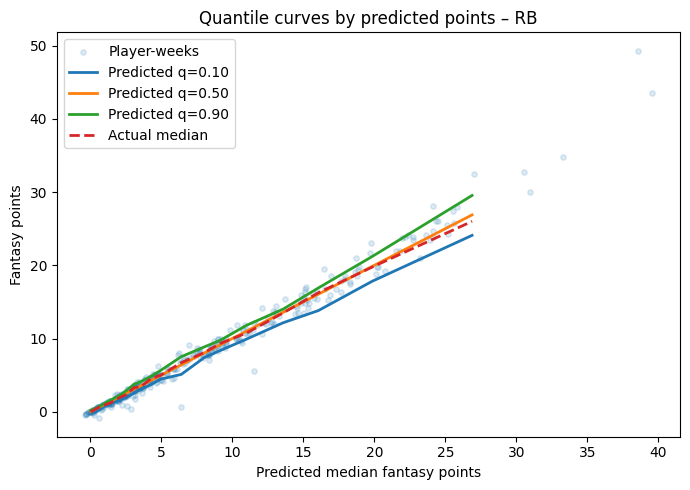

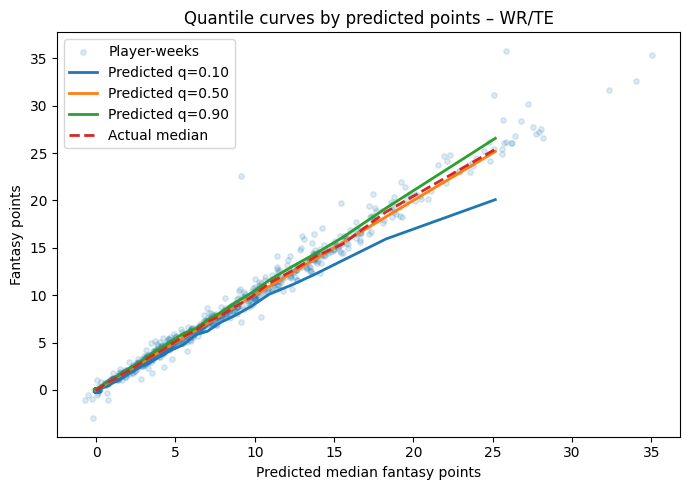

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_quantile_curves_by_position(df_predictions, position, n_bins=25):
    """
    Make a quantile fan plot for a single position, similar to the demo image:
      - x-axis: predicted median points (pred_50)
      - lines: avg predicted 10/50/90 quantiles
      - line: actual median in each bin (ground truth)
      - background: scatter of individual weeks
    """
    # Filter to this position
    df_pos = df_predictions[df_predictions['position'] == position].copy()
    if df_pos.empty:
        print(f"No rows found for position {position}")
        return

    # Sort by predicted median
    df_pos = df_pos.sort_values('pred_50')

    # Make quantile bins on pred_50 (avoid more bins than we have data for)
    nbins = min(n_bins, max(5, len(df_pos) // 20))
    df_pos['pred_bin'] = pd.qcut(df_pos['pred_50'], q=nbins, duplicates='drop')

    grouped = df_pos.groupby('pred_bin')

    # x = mean pred_50 in each bin
    x = grouped['pred_50'].mean()

    # predicted quantiles (averaged within bins)
    pred_q10 = grouped['pred_10'].mean()
    pred_q50 = grouped['pred_50'].mean()
    pred_q90 = grouped['pred_90'].mean()

    # "ground truth" curve: median actual in each bin
    actual_med = grouped['y_test'].median()

    # --- plot ---
    fig, ax = plt.subplots(figsize=(7, 5))

    # scatter points as background
    ax.scatter(df_pos['pred_50'], df_pos['y_test'],
               alpha=0.15, s=15, label='Player-weeks')

    # quantile curves
    ax.plot(x, pred_q10, linewidth=2, label='Predicted q=0.10')
    ax.plot(x, pred_q50, linewidth=2, label='Predicted q=0.50')
    ax.plot(x, pred_q90, linewidth=2, label='Predicted q=0.90')

    # ground truth median
    ax.plot(x, actual_med, linewidth=2, linestyle='--', label='Actual median')

    ax.set_xlabel('Predicted median fantasy points')
    ax.set_ylabel('Fantasy points')
    ax.set_title(f'Quantile curves by predicted points – {position}')
    ax.legend()
    plt.tight_layout()
    plt.show()




# Example: just QBs
plot_quantile_curves_by_position(df_predictions, position='QB')
plot_quantile_curves_by_position(df_predictions, position='RB')
plot_quantile_curves_by_position(df_predictions, position='WR/TE')


